<a href="https://colab.research.google.com/github/ferngndo/remote-sensing/blob/main/Classificacao_Supervisionada_Estudo_ipynb_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral
!pip install rasterio

     |████████████████████████████████| 212 kB 4.3 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


# Rasterização

In [ ]:
# Bibliotecas
from osgeo import gdal
from osgeo import ogr

In [ ]:
# Leitura dos arquivos
raster = gdal.Open('/content/drive/MyDrive/Curso PDI com Python/L71221071_07120010720_DN_B1.tif')
vetor = ogr.Open('/content/drive/MyDrive/Curso PDI com Python/ROI.shp')

In [ ]:
# Get layer
layer = vetor.GetLayer()

In [ ]:
# Armazenando parâmetros cartográficos
transform = raster.GetGeoTransform()

In [ ]:
# Criando o raster
driver = gdal.GetDriverByName('GTiff')
raster_roi = driver.Create('roi.tif',raster .RasterXSize, raster .RasterYSize, 1, gdal.GDT_Int16)
raster_roi.SetGeoTransform(transform)

0

In [ ]:
# Populando raster com o vetor
gdal.RasterizeLayer(raster_roi, [1], layer, options=['ATTRIBUTE=id'])
raster_roi.GetRasterBand(1).SetNoDataValue(0.0)
raster_roi = None

# KNN

In [ ]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/Curso PDI com Python/L71221071_07120010720_DN.tif')
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
b4 = src.read(4)
b5 = src.read(5)
b7 = src.read(6)

img = np.dstack([b1,b2,b3,b4,b5,b7])

In [ ]:
# Armazenando metadados
meta = src.profile

In [ ]:
# Lendo classes
with rio.open('/content/roi.tif') as src2:
  roi = src2.read(1)

In [ ]:
# Criando conjunto de treino
X = img[roi > 0]
y  = roi[roi > 0]

In [ ]:
# Dividindo conjunto em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size = 0.95)

In [ ]:
# Instanciando o classificador

knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [ ]:
# Criando matriz com bandas em colunas
img2d = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

# Rodando predição
pred_knn = knn.predict(img2d)

# Retornando para o formato original
pred_knn_final = pred_knn.reshape(img[:,:,0].shape)

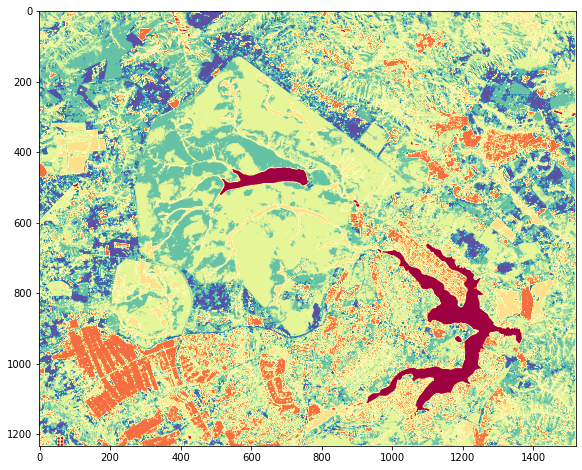

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(pred_knn_final, cmap='Spectral')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Classification report
pred = knn.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        89
           2       1.00      0.22      0.36       111
           3       1.00      1.00      1.00       154
           4       0.63      1.00      0.77       136
           5       0.00      0.00      0.00        98
           6       0.58      1.00      0.73       144

    accuracy                           0.75       732
   macro avg       0.70      0.70      0.64       732
weighted avg       0.71      0.75      0.67       732



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_score(y_test, pred)

0.7390710382513661

In [ ]:
# 1 - água
# 2 - urbano
# 3 - mata de galeria
# 4 - Cerrado1
# 5 - Cerrado2
# 6 - Solo exposto

In [ ]:
confusion_matrix(y_test, pred)

array([[ 89,   0,   0,   0,   0,   0],
       [  0,  25,   0,   0,   0,  88],
       [  0,   0, 151,   0,   0,   0],
       [  0,   0,   0, 136,   0,   0],
       [  0,   0,   0,  84,   0,  19],
       [  0,   0,   0,   0,   0, 140]])

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['y_teste'] = y_test
df['predito'] = pred

cross = pd.crosstab(df['y_teste'], df['predito'])



In [ ]:
cross.to_excel('knncross.xlsx')

In [ ]:
# Tunning de Hiperparâmetros
ks = [10,20,30,40,50,100,200,300,400,500]
accu = []

for i in ks:
  knn2 = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
  knn2.fit(X_train, y_train)
  pred2 = knn2.predict(X_test)
  accu.append(accuracy_score(y_test, pred2))
  print('Acurácia para k = {} é: {}'.format(i, accuracy_score(y_test, pred2)))

Acurácia para k = 10 é: 1.0
Acurácia para k = 20 é: 1.0
Acurácia para k = 30 é: 1.0
Acurácia para k = 40 é: 0.9956709956709957
Acurácia para k = 50 é: 0.9913419913419913
Acurácia para k = 100 é: 0.9437229437229437
Acurácia para k = 200 é: 0.6017316017316018
Acurácia para k = 300 é: 0.4025974025974026
Acurácia para k = 400 é: 0.38961038961038963
Acurácia para k = 500 é: 0.19913419913419914


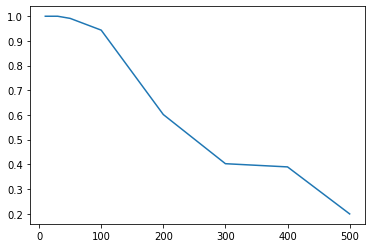

In [ ]:
plt.plot(ks, accu)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Instanciando
rf = RandomForestClassifier(n_estimators= 500, max_depth=1000, n_jobs=-1, oob_score=True)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=1000, n_estimators=500, n_jobs=-1,
                       oob_score=True)

In [ ]:
print(rf.oob_score_ * 100)

99.74025974025975


In [ ]:
rf.feature_importances_

array([0.12855577, 0.20154289, 0.22227912, 0.09159578, 0.15676974,
       0.1992567 ])

In [ ]:
# Rodando predição
pred_rf = rf.predict(img2d)

# Retornando para o formato original
pred_rf_final = pred_rf.reshape(img[:,:,0].shape)

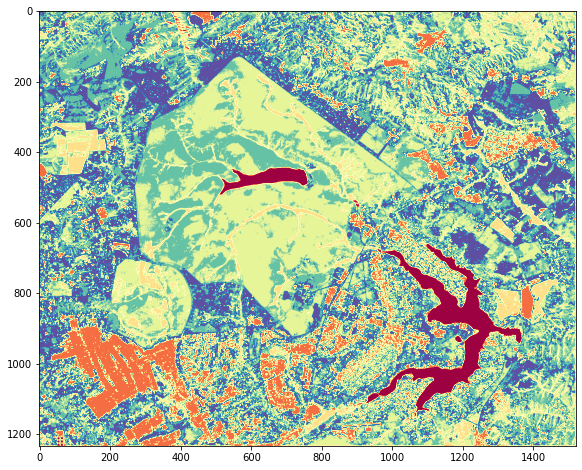

In [ ]:
# Visualizando
plt.figure(figsize=(12,8))
plt.imshow(pred_rf_final, cmap='Spectral')

In [ ]:
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90
           2       0.75      1.00      0.86       113
           3       1.00      1.00      1.00       151
           4       1.00      1.00      1.00       132
           5       1.00      1.00      1.00        99
           6       1.00      0.75      0.86       147

    accuracy                           0.95       732
   macro avg       0.96      0.96      0.95       732
weighted avg       0.96      0.95      0.95       732



In [ ]:
confusion_matrix(y_test, pred)

array([[ 90,   0,   0,   0,   0,   0],
       [  0, 113,   0,   0,   0,   0],
       [  0,   0, 151,   0,   0,   0],
       [  0,   0,   0, 132,   0,   0],
       [  0,   0,   0,   0,  99,   0],
       [  0,  37,   0,   0,   0, 110]])

In [ ]:
# Tunning de Hiperparâmetros
depth = [1,5,10,15,25,50,100,200,30,400,500]
accu = []

for i in depth:
  rf2 = RandomForestClassifier(n_estimators= i, max_depth=1000, n_jobs=-1)
  rf2.fit(X_train, y_train)
  pred3 = rf2.predict(X_test)
  accu.append(accuracy_score(y_test, pred3))
  print('Acurácia para árvores = {} é: {}'.format(i, accuracy_score(y_test, pred3)))

Acurácia para árvores = 1 é: 0.9016393442622951
Acurácia para árvores = 5 é: 0.9781420765027322
Acurácia para árvores = 10 é: 0.9631147540983607
Acurácia para árvores = 15 é: 0.9849726775956285
Acurácia para árvores = 25 é: 0.9849726775956285
Acurácia para árvores = 50 é: 0.9836065573770492
Acurácia para árvores = 100 é: 0.9836065573770492
Acurácia para árvores = 200 é: 0.9863387978142076
Acurácia para árvores = 30 é: 0.9904371584699454
Acurácia para árvores = 400 é: 0.9836065573770492
Acurácia para árvores = 500 é: 0.9836065573770492


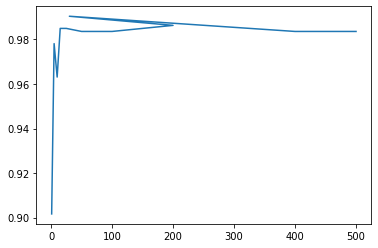

In [ ]:
plt.plot(depth, accu)

# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Instanciando
svm = SVC()

svm.fit(X_train, y_train)

SVC()

In [ ]:
# Rodando predição
pred_svm = svm.predict(img2d)

# Retornando para o formato original
pred_svm_final = pred_svm.reshape(img[:,:,0].shape)

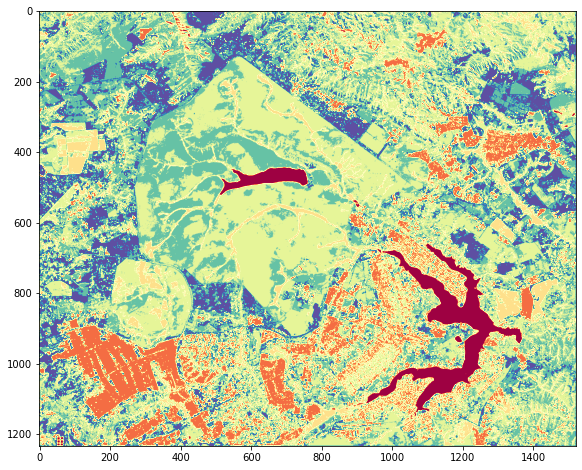

In [ ]:
# Visualizando
plt.figure(figsize=(12,8))
plt.imshow(pred_svm_final, cmap='Spectral')

In [ ]:
pred = svm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        89
           2       1.00      0.85      0.92       111
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00       136
           5       1.00      1.00      1.00        98
           6       0.89      1.00      0.94       144

    accuracy                           0.98       732
   macro avg       0.98      0.97      0.98       732
weighted avg       0.98      0.98      0.98       732



In [ ]:
confusion_matrix(y_test, pred)

array([[ 89,   0,   0,   0,   0,   0],
       [  0,  94,   0,   0,   0,  17],
       [  0,   0, 154,   0,   0,   0],
       [  0,   0,   0, 136,   0,   0],
       [  0,   0,   0,   0,  98,   0],
       [  0,   0,   0,   0,   0, 144]])

# Salvando em disco

In [ ]:
meta.update({'count': 1})

In [ ]:
lista = [pred_knn_final, pred_rf_final, pred_svm_final]
lista_nomes = ['knn.tif', 'rf.tif', 'svm.tif']

In [ ]:
# Gravando em disco
for i in range(3):
  with rio.open(lista_nomes[i], 'w', **meta) as src:
    src.write(lista[i],1)